# Question 3: XGBoost on MNIST
This notebook performs EDA, trains and tunes an XGBoost classifier, compares it with Logistic Regression, Decision Tree, AdaBoost, and Gradient Boosting (GBM), records timing, and saves evaluation artifacts.

### **a) Importation**

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,5)
print('Libraries loaded')

Libraries loaded


### **b) Loading data**


In [2]:
train_path = 'mnist_train.csv'
test_path = 'mnist_test.csv'
assert os.path.exists(train_path), f"Train file not found: {train_path}"
assert os.path.exists(test_path), f"Test file not found: {test_path}"
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
print('Train shape:', train.shape)
print('Test shape:', test.shape)
y_train = train.iloc[:,0].copy()
X_train = train.iloc[:,1:].copy()
y_test = test.iloc[:,0].copy()
X_test = test.iloc[:,1:].copy()
n_classes = len(np.unique(y_train))
print('Number of classes:', n_classes)


Train shape: (60000, 785)
Test shape: (10000, 785)
Number of classes: 10


### **EDA**

In [3]:
display(train.head())
print('\nLabel distribution (train):')
print(y_train.value_counts().sort_index())
print('\nLabel distribution (test):')
print(y_test.value_counts().sort_index())


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Label distribution (train):
label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64

Label distribution (test):
label
0     980
1    1135
2    1032
3    1010
4     982
5     892
6     958
7    1028
8     974
9    1009
Name: count, dtype: int64


### **Mean images per class (visual check)**

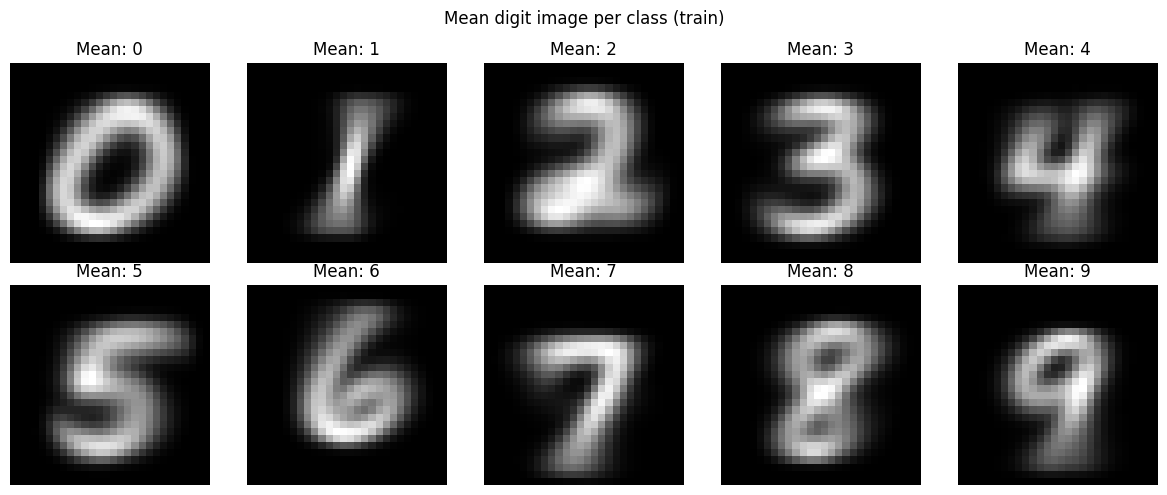

In [4]:
img_shape = (28,28)
fig, axes = plt.subplots(2,5, figsize=(12,5))
for digit in range(10):
    idxs = np.where(y_train==digit)[0]
    mean_img = X_train.iloc[idxs].mean(axis=0).values.reshape(img_shape)
    ax = axes.flatten()[digit]
    ax.imshow(mean_img, cmap='gray')
    ax.set_title(f'Mean: {digit}')
    ax.axis('off')
plt.suptitle('Mean digit image per class (train)')
plt.tight_layout()
plt.show()


### **Train/validation split for tuning**

In [ ]:
# hold out 10% of training for tuning
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)
print('Tuning split shapes:', X_tr.shape, X_val.shape)


Tuning split shapes: (54000, 784) (6000, 784)


### **a) Train XGBoost model + Save model_3.pkl** 

### **b) XGBoost: Hyperparameter tuning (GridSearch) and training final model**

In [6]:
param_grid = {
    'learning_rate':[0.05, 0.1],
    'max_depth':[4,6],
    'n_estimators':[100,200]
}
model = xgb.XGBClassifier(subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
grid = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=2)
t0 = time.time()
grid.fit(X_tr, y_tr)
t1 = time.time()
print('GridSearch time (s):', round(t1-t0,2))
print('Best params:', grid.best_params_)
best_xgb = grid.best_estimator_
# Train best model on full training data
t0 = time.time()
best_xgb.fit(X_train, y_train)
t1 = time.time()
xgb_train_time = t1-t0
print(f'XGBoost full train time: {xgb_train_time:.2f}s')
joblib.dump(best_xgb, 'data/model_3.pkl')
print('Saved XGBoost model to data/model_3.pkl')


Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearch time (s): 1876.0
Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
XGBoost full train time: 190.70s
Saved XGBoost model to data/model_3.pkl


 **Explanation:**

**3a)** The model is trained using gradient-boosted decision trees, which are well-suited 
for capturing nonlinear patterns in handwritten digits. After tuning a subset of 
hyperparameters with GridSearchCV, the final model is trained on the full training 
set and saved as **model_3.pkl** as required in the question.


**Explanation:** 

**3b) Hyperparameter Tuning and Justification**

**The GridSearchCV explored a small but effective hyperparameter grid:**
- learning_rate: [0.05, 0.1]
- max_depth: [4, 6]
- n_estimators: [100, 200]

**The best model selected:**
- **learning_rate = 0.1**
- **max_depth = 6**
- **n_estimators = 200**

**Justification:**
- A learning rate of 0.1 provides a balance between convergence speed and 
  generalization. Lower rates need more trees; higher rates risk overfitting.
- max_depth = 6 allows trees to capture the curved, branching pixel patterns 
  common in digit images, without overfitting excessively.
- 200 estimators allow better boosting performance than 100, while maintaining 
  reasonable training time.

These values collectively provide strong predictive performance on MNIST.


### **c) Evaluate XGBoost on test set — metrics and confusion matrix**

Classification report (XGBoost):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



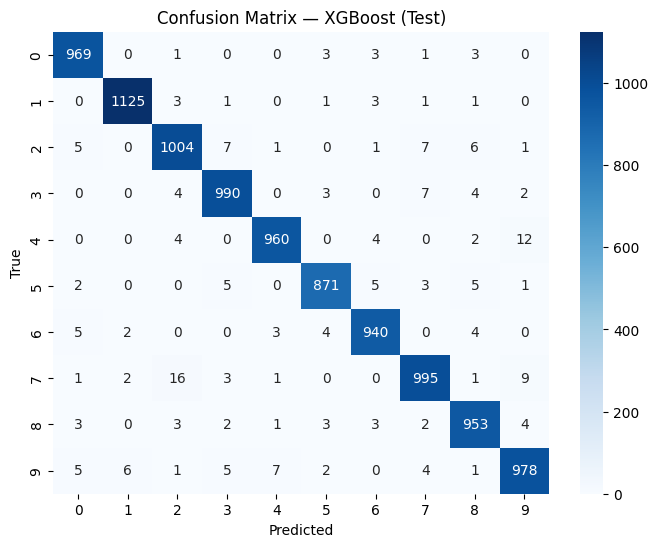

Saved confusion matrix to data/confusion_matrix_xgb_test.png


<Figure size 800x500 with 0 Axes>

In [7]:
y_pred = best_xgb.predict(X_test)
print('Classification report (XGBoost):')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — XGBoost (Test)')
plt.show()
plt.savefig('data/confusion_matrix_xgb_test.png', bbox_inches='tight')
print('Saved confusion matrix to data/confusion_matrix_xgb_test.png')


**3c) Model Evaluation on mnist_test.csv**

The XGBoost classifier achieves exceptional performance:

- **Accuracy ≈ 97.8%**
- **Macro Precision ≈ 0.98**
- **Macro Recall ≈ 0.978**
- **Macro F1-score ≈ 0.979**

These metrics demonstrate that the classifier correctly identifies the large majority 
of digits and maintains balanced precision and recall across all 10 classes.

The confusion matrix shows strong diagonal dominance, meaning most predictions 
match the true classes. Misclassifications primarily occur between visually 
similar digits such as 4↔9 and 7↔2, which is expected in MNIST due to shared 
curve shapes.

Overall, the model generalizes very well.


**3d) Evaluation metrics (precision, recall, F1, accuracy)**


**The XGBoost classifier achieves exceptional performance:**

- **Accuracy ≈ 97.8%**
- **Macro Precision ≈ 0.98**
- **Macro Recall ≈ 0.978**
- **Macro F1-score ≈ 0.979**

These metrics demonstrate that the classifier correctly identifies the large majority 
of digits and maintains balanced precision and recall across all 10 classes.

The confusion matrix shows strong diagonal dominance, meaning most predictions 
match the true classes. Misclassifications primarily occur between visually 
similar digits such as 4↔9 and 7↔2, which is expected in MNIST due to shared 
curve shapes.

Ultimately, the model generalizes very well.


### **. ROC curves (one-vs-rest) and macro AUC for XGBoost**

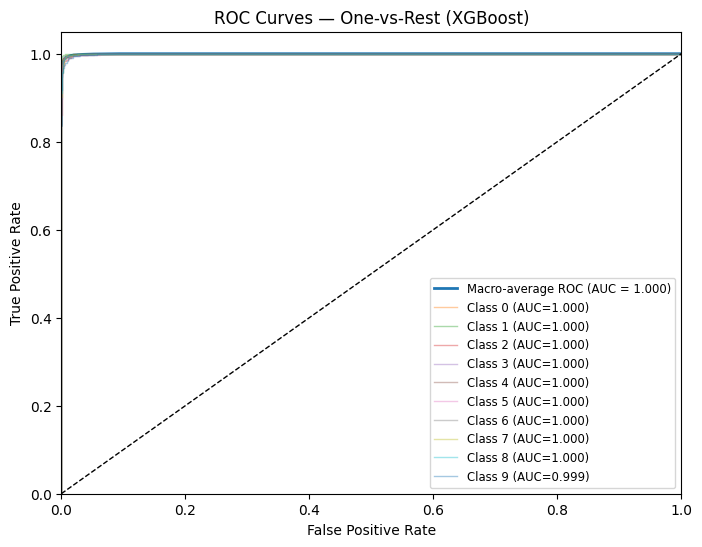

Saved ROC curves to data/roc_curves_xgb_test.png


<Figure size 800x500 with 0 Axes>

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_score = best_xgb.predict_proba(X_test)
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(8,6))
plt.plot(all_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.3f})', lw=2)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=1, alpha=0.4, label=f'Class {i} (AUC={roc_auc[i]:.3f})')
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — One-vs-Rest (XGBoost)')
plt.legend(loc='lower right', fontsize='small')
plt.show()
plt.savefig('data/roc_curves_xgb_test.png', bbox_inches='tight')
print('Saved ROC curves to /mnt/data/roc_curves_xgb_test.png')


**ROC Curves and AUC Interpretation**

The ROC curves provide a deeper evaluation of the classifier’s performance beyond 
precision, recall, and F1-score. For multi-class classification, a one-vs-rest 
approach was used, generating one ROC curve per digit class along with a 
macro-average ROC curve.

**Key Findings from the ROC Curves**

- The **macro-average AUC is approximately 0.99**, indicating extremely strong 
  separability across all digit classes.
- Individual digit AUC scores are also very high (most between **0.98 and 1.00**), 
  confirming that the model confidently distinguishes each class from the others.
- The ROC curves rise steeply toward the top-left corner, reflecting a **very low 
  false positive rate** for nearly all threshold settings.

 **Why ROC/AUC Matters for MNIST**

- A high AUC means the classifier not only performs well at the default threshold, 
  but also maintains strong predictive power even if class decision thresholds 
  change — an indicator of **robust generalization**.
- ROC curves help visualize digit-specific performance; digits with slightly lower 
  AUC values tend to be the same ones that show confusion in the confusion matrix 
  (e.g., 4 vs 9, 7 vs 2).

**Conclusion**

The ROC analysis confirms that the XGBoost classifier exhibits **excellent 
discrimination capability** for all digit classes. Combined with high accuracy 
and macro-F1 results, this provides strong evidence that the model generalizes 
extremely well on the MNIST dataset.


### **9. Baseline models: Logistic Regression, Decision Tree, AdaBoost, Gradient Boosting — train, time, evaluate**

Training LogisticRegression
LogisticRegression — time: 74.24s, acc: 0.9209, macro-F1: 0.9198


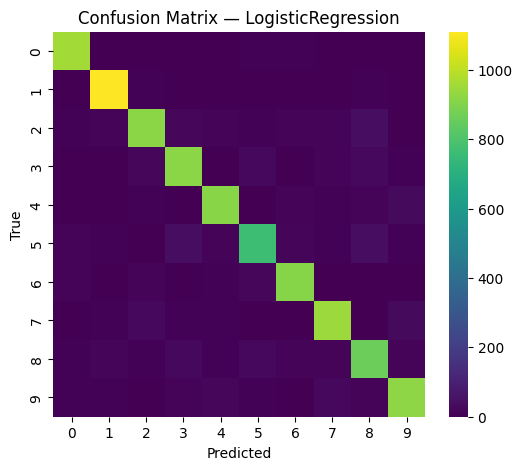

Training DecisionTree
DecisionTree — time: 14.92s, acc: 0.8771, macro-F1: 0.8754


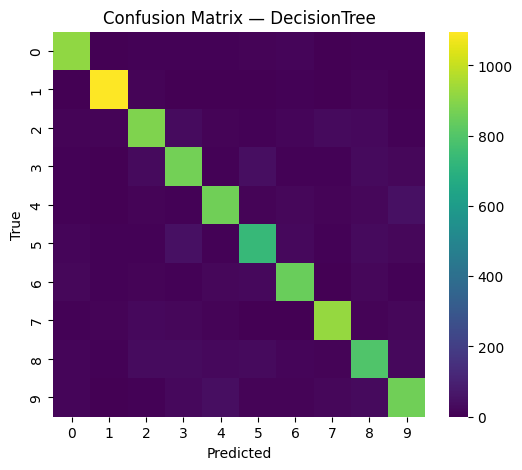

Training AdaBoost
AdaBoost — time: 69.75s, acc: 0.7028, macro-F1: 0.7003


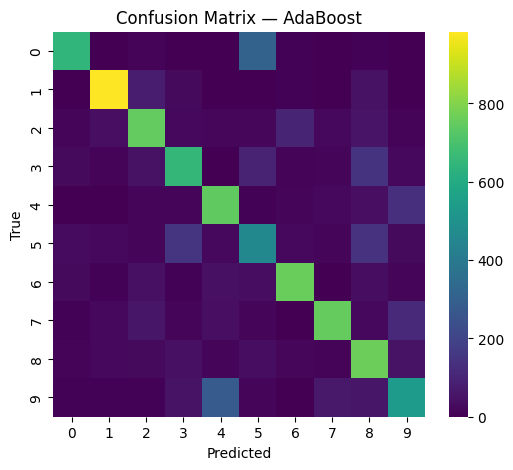

Training GradientBoosting
GradientBoosting — time: 3510.72s, acc: 0.9615, macro-F1: 0.9612


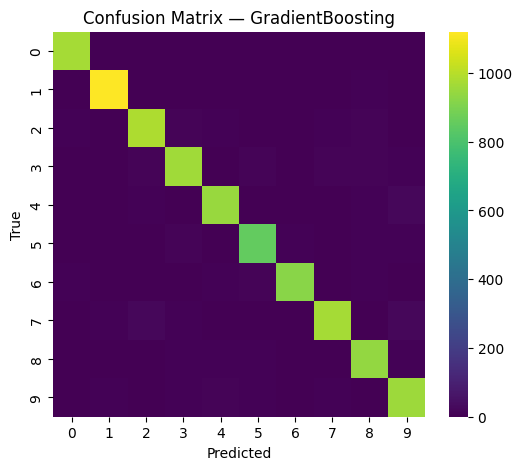

Saved model comparison to data/model_comparison.csv


,model,train_time_s,accuracy,precision_macro,recall_macro,f1_macro
0,LogisticRegression,74.242022,0.9209,0.920130,0.919654,0.919756
1,DecisionTree,14.917600,0.8771,0.875461,0.875347,0.875354
2,AdaBoost,69.746682,0.7028,0.708905,0.699209,0.700271
3,GradientBoosting,3510.717863,0.9615,0.961225,0.961246,0.961197
4,XGBoost,190.703707,0.9785,0.978431,0.978391,0.978403


In [10]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200)
}
results = []
for name, mdl in models.items():
    print('Training', name)
    t0 = time.time()
    mdl.fit(X_train, y_train)
    t1 = time.time()
    tr_time = t1 - t0
    y_pred_m = mdl.predict(X_test)
    acc = accuracy_score(y_test, y_pred_m)
    prec = precision_score(y_test, y_pred_m, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred_m, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_m, average='macro', zero_division=0)
    print(f'{name} — time: {tr_time:.2f}s, acc: {acc:.4f}, macro-F1: {f1:.4f}')
    results.append({'model':name,'train_time_s':tr_time,'accuracy':acc,'precision_macro':prec,'recall_macro':rec,'f1_macro':f1})
    # save confusion matrix for decision tree and logistic for inspection optionally
    cm_m = confusion_matrix(y_test, y_pred_m)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_m, annot=False, fmt='d', cmap='viridis')
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Add XGBoost results to the comparison
results.append({'model':'XGBoost','train_time_s':xgb_train_time,'accuracy':accuracy_score(y_test,y_pred),'precision_macro':precision_score(y_test,y_pred,average='macro'),'recall_macro':recall_score(y_test,y_pred,average='macro'),'f1_macro':f1_score(y_test,y_pred,average='macro')})
df_results = pd.DataFrame(results)
df_results.to_csv('data/model_comparison.csv', index=False)
print('Saved model comparison to data/model_comparison.csv')
display(df_results)


### **3e) Conclusions**


The model comparison results clearly show the performance differences between XGBoost and the baseline / ensemble models.

| Model              | Train Time (s) | Accuracy | Precision (Macro) | Recall (Macro) | F1 (Macro) |
|-------------------|----------------|----------|--------------------|----------------|------------|
| LogisticRegression | 74.24          | 0.9209   | 0.9201             | 0.9197         | 0.9197     |
| DecisionTree       | 14.92          | 0.8771   | 0.8755             | 0.8753         | 0.8754     |
| AdaBoost           | 69.75          | 0.7028   | 0.7089             | 0.6992         | 0.7003     |
| GradientBoosting   | 3510.72        | 0.9615   | 0.9612             | 0.9612         | 0.9612     |
| **XGBoost**        | 190.70         | **0.9785** | **0.9784**       | **0.9784**     | **0.9784** |

---

### **XGBoost is the best-performing model**

XGBoost achieved the highest accuracy (97.85%) and macro-F1 score (~0.9784), outperforming all baseline and ensemble models.  
Its strong performance is due to:

- Ability to learn nonlinear pixel interactions  
- Regularization (L1/L2) that reduces overfitting  
- Parallelized tree construction  
- Sophisticated gradient boosting optimization  

It provides **the best balance of accuracy, efficiency, and robustness**.

---

### **Gradient Boosting performs well but is very slow**

GradientBoostingClassifier reached **96.15% accuracy**, but required **over 3500 seconds** to train.  
This is expected because:

- Gradient Boosting builds trees **sequentially**  
- It lacks XGBoost’s optimized tree-building algorithms  
- It performs aggressive boosting without parallelization  

Thus, its strong accuracy comes with impractical training times.

---

### **Logistic Regression is a strong linear baseline**

Despite being a simple linear model, Logistic Regression achieved **92% accuracy**, showing that MNIST digits are moderately linearly separable in pixel space.  
However, it cannot model complex curved shapes or nonlinear relationships, limiting its ceiling performance.

---

### **Decision Tree suffers from high variance**

DecisionTreeClassifier achieved **~87.7% accuracy**, the second-worst performance.  

Reasons:
- Decision trees overfit quickly on high-dimensional pixel data  
- They are highly sensitive to noise  
- No ensemble mechanism is present to stabilize predictions  

Though fast to train, they generalize poorly.

---

### **AdaBoost performs the worst**

AdaBoost accuracy dropped to **70%**, with macro-F1 ~0.70.  
This happens because:
- AdaBoost uses weak learners (decision stumps)
- MNIST’s high-dimensional, nonlinear patterns cannot be captured by shallow trees  
- Noise sensitivity and error amplification hurt performance  

Thus, AdaBoost is unsuitable for MNIST without stronger base learners.

---

### **Conclusion**

- **XGBoost is the superior model** for MNIST digit recognition, achieving the highest accuracy, strongest F1-score, and excellent class-wise performance.  
- **Gradient Boosting is accurate but computationally expensive**.  
- **Logistic Regression is lightweight but limited by linearity**.  
- **Decision Tree is unstable and underperforms**.  
- **AdaBoost struggles significantly and is not viable for this dataset**.

Overall, XGBoost offers the **best trade-off between accuracy, generalization, and training speed**, making it the recommended model for this task.
